In [1]:
# the code ref from tensorflow word2vec_basic.py
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random

import numpy as np
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

import numpy as np
import pandas as pd

In [2]:
f = open('./data/ipinyou/training_not_aligned.csv','r')
raw_data = []
for line in f.readlines():
    raw_data.append([int(x) for x in line.strip().split(',')])

In [3]:
reverse_dictionary_raw = np.array(pd.read_csv('./data/ipinyou/reverse_dictionary_not_aligned.csv',sep=',',header=None))
reverse_dictionary = {}
dictionary = {}

In [4]:
vocabulary_size = 0
for item in reverse_dictionary_raw:
    reverse_dictionary[item[1]] = item[0]
    dictionary[item[0]] = item[1]
    if item[1] > vocabulary_size:
        vocabulary_size = item[1]
vocabulary_size = vocabulary_size + 1
print('vocabulary_size: ',vocabulary_size)

vocabulary_size:  1272384


In [5]:
fields_index = {} 
f = open('./data/ipinyou/field_cates_index_not_aligned.csv','r')
for line in f.readlines():
    field_name, indices = line.strip().split('\t')
    indices = np.array([int(i) for i in indices.split(',')])
    fields_index[field_name] = indices

In [6]:
data_index = 0
def generate_batch(batch_size, num_skips):
    global data_index
    assert batch_size % num_skips == 0
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    for i in range(batch_size // num_skips):
        span = len(data[data_index])
        label_index = random.randint(1, span - 1)  # target label at the center of the buffer
        singe_data = data[data_index]
        targets_to_avoid = [label_index]
        target = label_index
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(1, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = singe_data[label_index]
            labels[i * num_skips + j, 0] = singe_data[target]
        data_index = (data_index + 1) % len(data)
    return batch, labels

def generate_batch_cbow(batch_size, num_skips):
    '''
    Batch generator for CBOW (Continuous Bag of Words).
    '''
    global data_index
    batch = np.ndarray(shape=(batch_size, num_skips), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    # move the sliding window
    for i in range(batch_size):
        span = len(data[data_index])
        label_index = random.randint(1, span - 1)
        singe_data = data[data_index]
        labels[i, 0] = singe_data[label_index]
        
        targets_to_avoid = [label_index]
        target = label_index
        sample = []
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(1, span - 1)
            targets_to_avoid.append(target)
            sample.append(singe_data[target])
        batch[i] = sample
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [7]:
# generate_batch_cbow([range(10) for x in range(10),8,4)

In [8]:
data = raw_data

In [9]:
batch_size = 64
embedding_size = 32  # Dimension of the embedding vector.
num_skips = 4         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

graph = tf.Graph()

architecture = 'cbow' # or 'cbow'

with graph.as_default():
    # Input data.
    if architecture == 'skip-gram':
        train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    elif architecture == 'cbow':
        train_inputs = tf.placeholder(tf.int32, shape=[batch_size, num_skips])
#     train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
        embeddings = tf.Variable(
                tf.random_normal([vocabulary_size,
                                  embedding_size],
                                 stddev=1.0 / np.sqrt(embedding_size)
                                 ))
#         embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    if architecture == 'skip-gram':
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    elif architecture == 'cbow':
        embed = tf.zeros([batch_size, embedding_size])
        for j in range(num_skips):
            embed += tf.nn.embedding_lookup(embeddings, train_inputs[:, j])
    
    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    
    if architecture == 'skip-gram':
         losses = tf.nn.nce_loss(weights, biases, embed, train_labels,
                     num_sampled, vocabulary_size)
    elif architecture == 'cbow':
         losses = tf.nn.sampled_softmax_loss(weights, biases, embed, train_labels,
                     num_sampled, vocabulary_size)
    
    loss = tf.reduce_mean(losses)

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
    similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)
    
    field_cates = tf.placeholder(dtype=tf.int32)
    field_embs = tf.gather(embeddings, field_cates)
    center_point = tf.reduce_mean(field_embs, 0)
    field_embs_shape = field_cates.get_shape()
#     print(field_embs_shape)
#     center_point = tf.tile(center_point,[field_embs_shape[0],1])
    avg_distance = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.pow(tf.sub(center_point, field_embs), 2),1)),0)

    # Add variable initializer.
    init = tf.initialize_all_variables()

In [10]:
num_steps = 1000001

with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print("Initialized")

    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch_cbow(
            batch_size, num_skips)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 1000000 == 0:
            if step > 0:
                average_loss /= 1000000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 1000000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
            avg_distacnes = []
            for field_name in fields_index.keys():
                field_indices = fields_index.get(field_name)
                field_feed_dict = {field_cates: field_indices}
                distance = session.run([avg_distance], feed_dict=field_feed_dict)
                avg_distacnes.extend(distance)
                print('avg distance for field:',field_name,':',distance)
            print('avg distance for all field:',np.mean(avg_distacnes))
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  10.9021549225
Nearest to hour_12: ip_219.155.92.*, ip_14.209.52.*, ip_114.89.128.*, ip_60.221.224.*, ip_180.213.155.*, url_7c60389fd6a9b2a4ea92249f0eac1e3b, url_8237228cc752fa5925eda8d046a29904, url_76c9828cc87c23dbbc4955b35233abe1,
Nearest to time_day_06: url_6568f39bff7a0d26f6fbc85fd7418bf5, url_80658a556d8c7628d50414dff8f74754, ip_27.197.110.*, url_98ef06abbf63e40bef81fc13ab2c263, ip_58.52.185.*, url_40c24237f3d1d8a33c6e68c282797369, url_bfae84986847c2f8946e30a501de049, ip_110.155.172.*,
Nearest to ad_exchange_1: url_da7a057acfdf168ce638ee4a60ddeb53, ip_123.5.193.*, url_7419e60444eda75a9109544c8b48e2ab, ip_180.137.100.*, ip_171.216.181.*, url_c35d97ef040c47be16b6844100a133ba, url_43801199575c073a0d29aa0d99f1f36b, url_324fd8ce1574052fbd2544185401f8b8,
Nearest to hour_20: url_47dec0b20f02080f3cf39f9ba5f0ea90, url_4380b8ffdc3a2a2378def74d072f35db, url_61558ca097494cde4b73bfbfbc2a472f, url_bc52e0707ea562072a263dbc5ece411a, url_522d14dece59139085b40

In [11]:
f = open('./data/ipinyou/pre_trained_embs_1272384_cboc_32.csv','w')
for line in final_embeddings:
    f.write(','.join([str(l) for l in line])+'\n')
f.close()
print(np.array(final_embeddings).shape)

(1272384, 32)


In [21]:
field_cate_indices_path = './data/ipinyou/field_cates_index_not_aligned.csv'
fields_index = {}
fields_index_inverse = {}
f = open(field_cate_indices_path, 'r')

for line in f.readlines():
    field_name, indices = line.strip().split('\t')
    indices = np.array([int(i) for i in indices.split(',')])
    fields_index[field_name] = indices
    for ind in indices:
        fields_index_inverse[ind] = field_name

In [22]:
%matplotlib inline
figure_base_path = './figure/'
import matplotlib.patches as mpatches
def get_colors(cates):
    import six
    from matplotlib import colors
    colors_ = list(six.iteritems(colors.cnames))
    cates_set = list(set(cates))
    colors_mapping = {}
    for i in range(len(cates_set)):
        colors_mapping[cates_set[i]] = colors_[i][0]
    colors_mapping
    cates = [colors_mapping.get(c) for c in cates]
    return cates

def plot_with_labels(low_dim_embs, labels, cates, filename='all_500sample.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(30, 20))  #in inches
    cates_c = get_colors(cates)
    for color, cate in set(zip(cates_c,cates)):
        x, y = low_dim_embs[0,:]
        plt.scatter(x, y, c=color, label=cate, s=300, alpha=0.7, edgecolors='none')
    
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y, c=cates_c[i], s=300, alpha=0.7, edgecolors='none')
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(0.8, 0.95),
                 textcoords='offset points',
                 ha='right',
                 va='top',
                    size=20)
    plt.legend()
    plt.savefig(figure_base_path + filename,format='pdf', )
    plt.show()


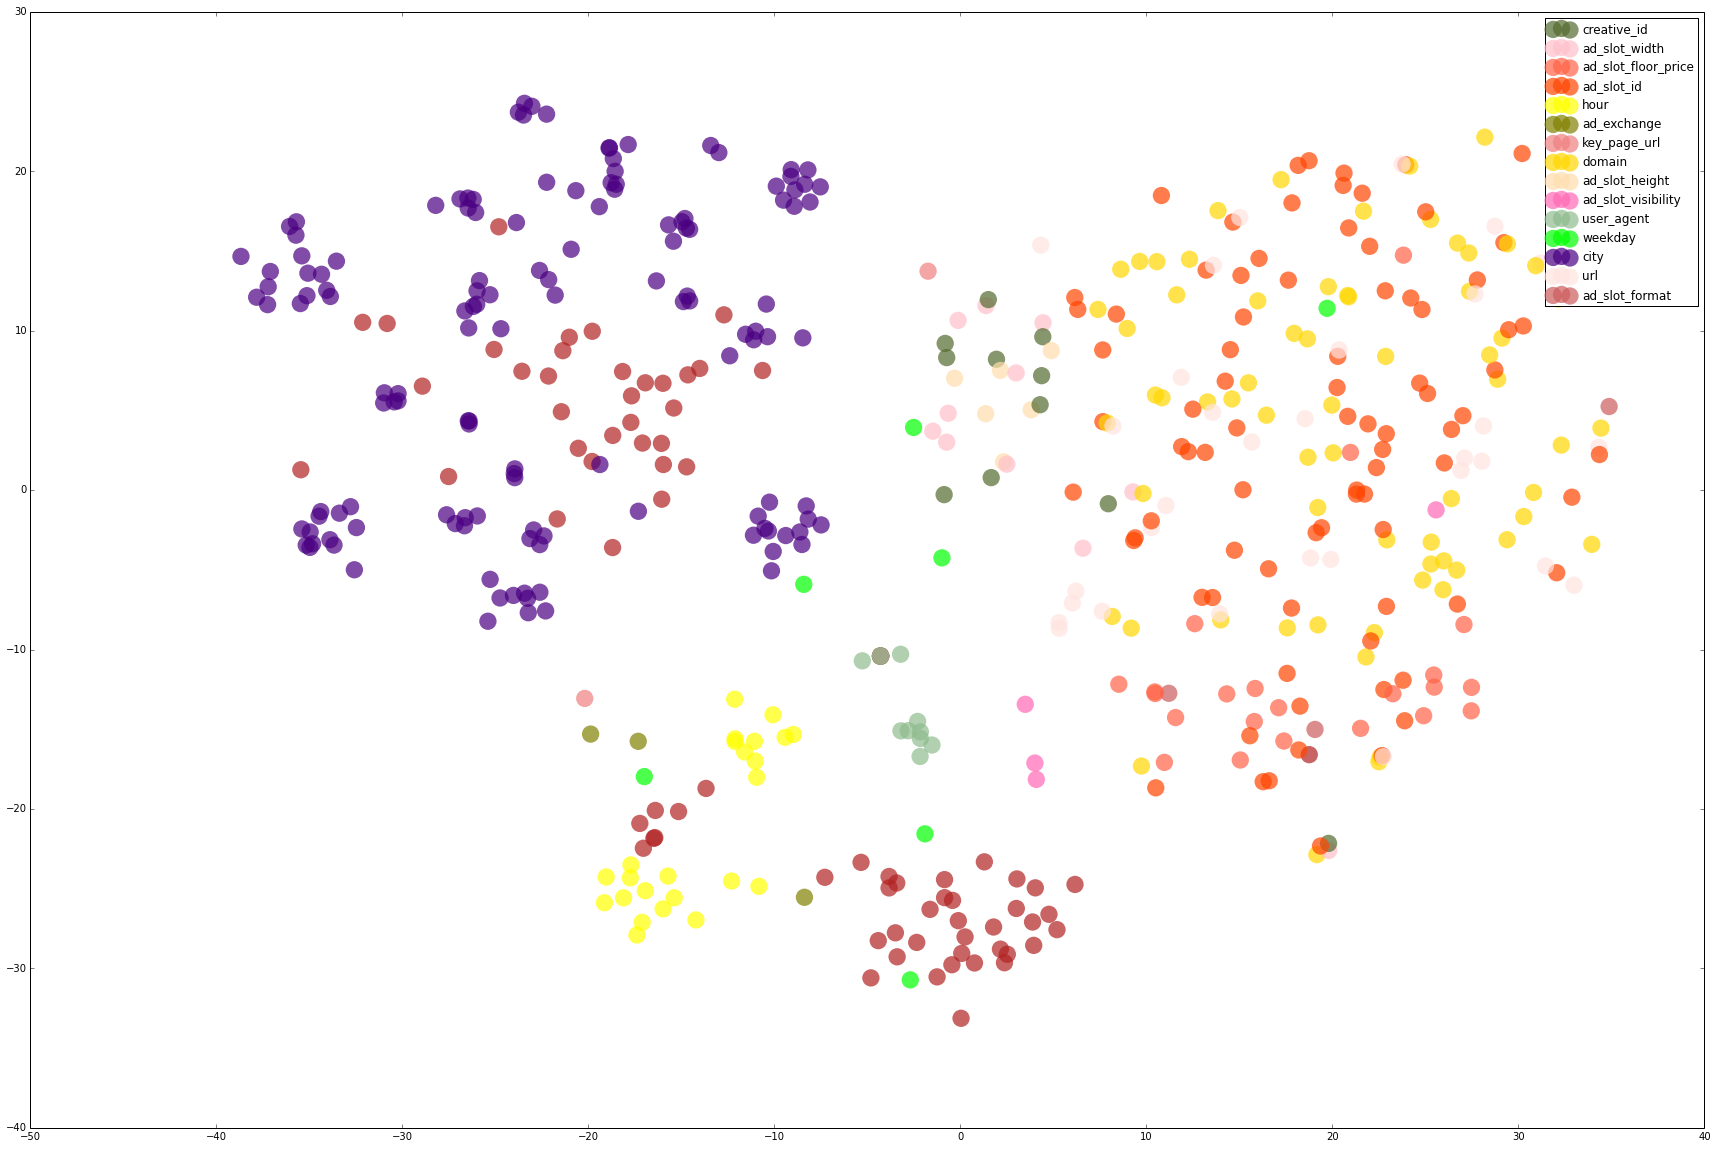

In [31]:
try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    tsne = TSNE(perplexity=20, n_components=2, init='pca', n_iter=5000)
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
    # reverse_dictionary[i].split('_')[-1][0:10]
    labels = ['' for i in xrange(plot_only)]
    cates = [fields_index_inverse.get(i) for i in xrange(plot_only)]
#     cates = ['_'.join(cat) for cat in cates]
    plot_with_labels(low_dim_embs, labels, cates ,filename='all_500_cboc_32_1272384.pdf')

except ImportError:
    print("Please install sklearn and matplotlib to visualize embeddings.")



In [14]:
# colors

# set(cates

# Figure for city and region

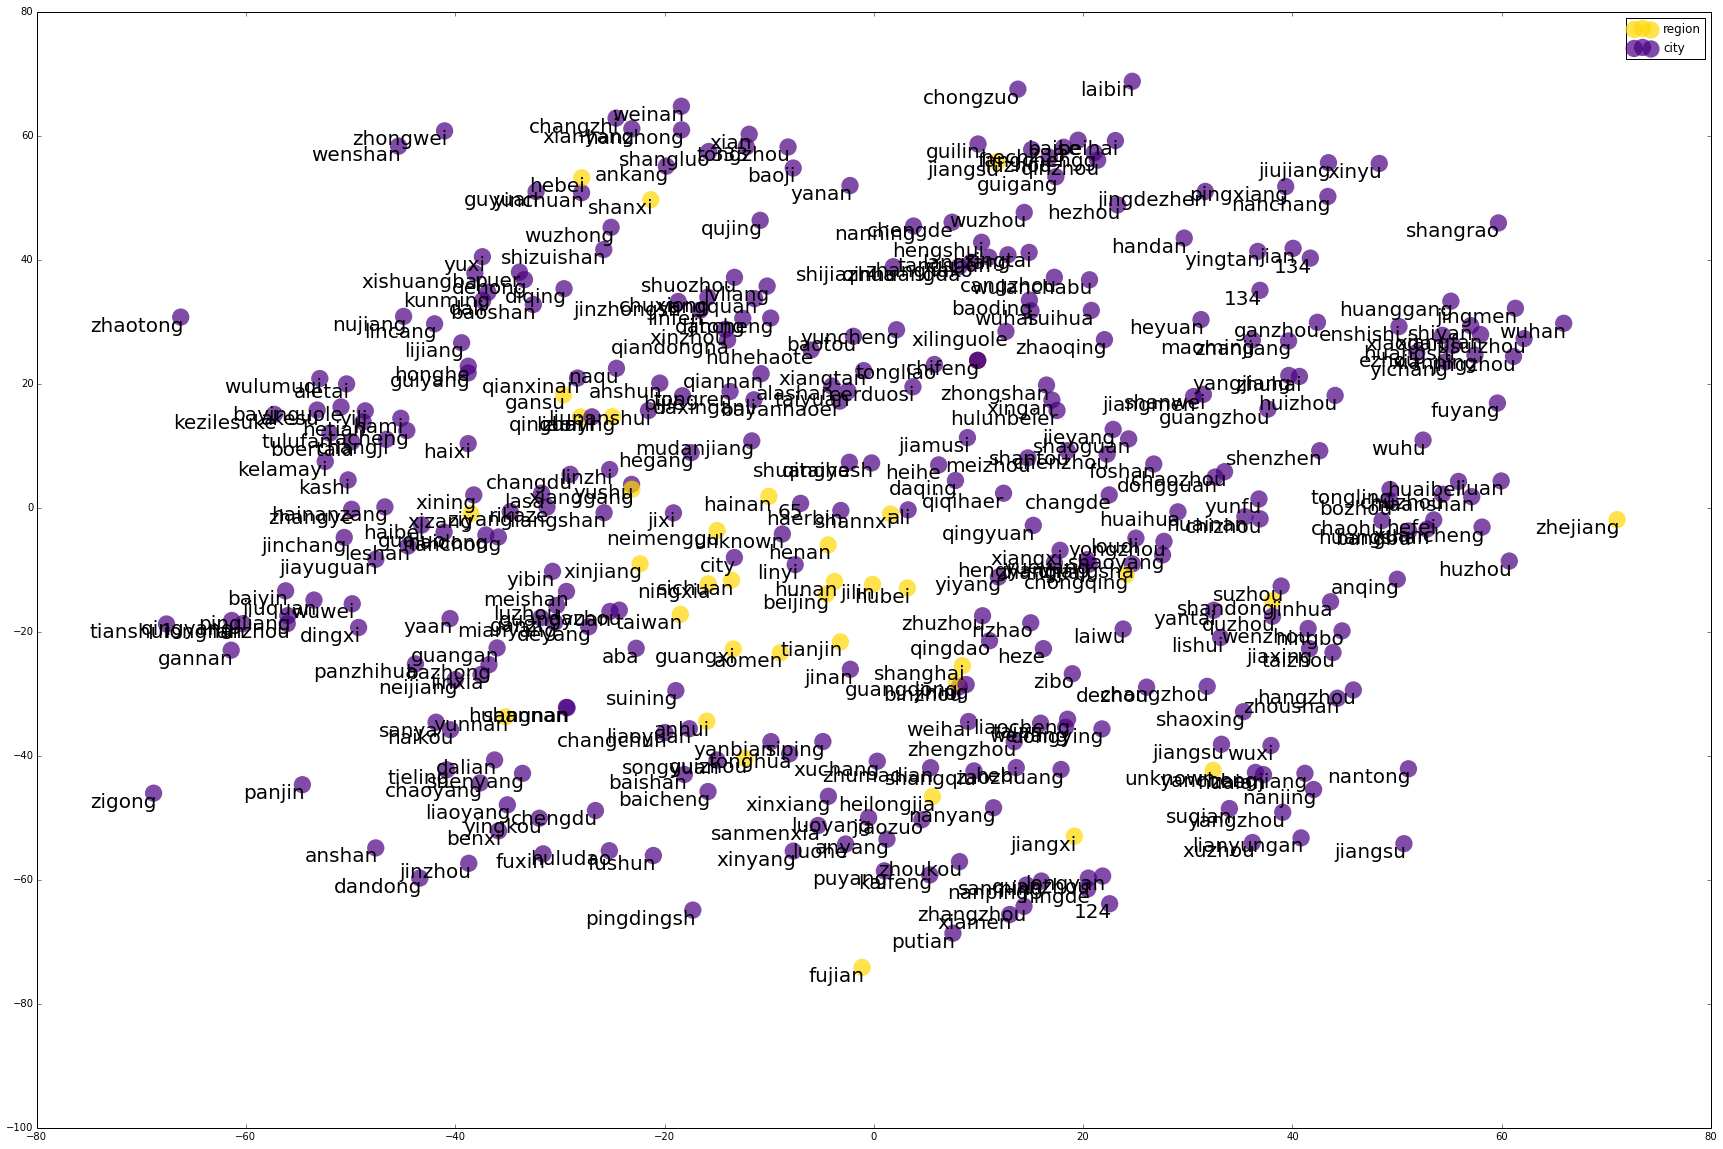

In [24]:
# for city and region
index = []
for key in dictionary.keys():
    if 'city' in key or 'region' in key:
        index.append(dictionary[key])
tsne = TSNE(perplexity=10, n_components=2, init='pca', n_iter=1500)
low_dim_embs = tsne.fit_transform(final_embeddings[index])
labels = [reverse_dictionary[i].split('_')[-1][0:10] for i in index]
cates = [reverse_dictionary[i].split('_')[0] for i in index]
# cates = ['_'.join(cat) for cat in cates]
plot_with_labels(low_dim_embs, labels, cates ,filename='city_region_cboc_32_1272384.pdf')
# plot_with_labels(low_dim_embs, labels, c, )

# Figure for tag

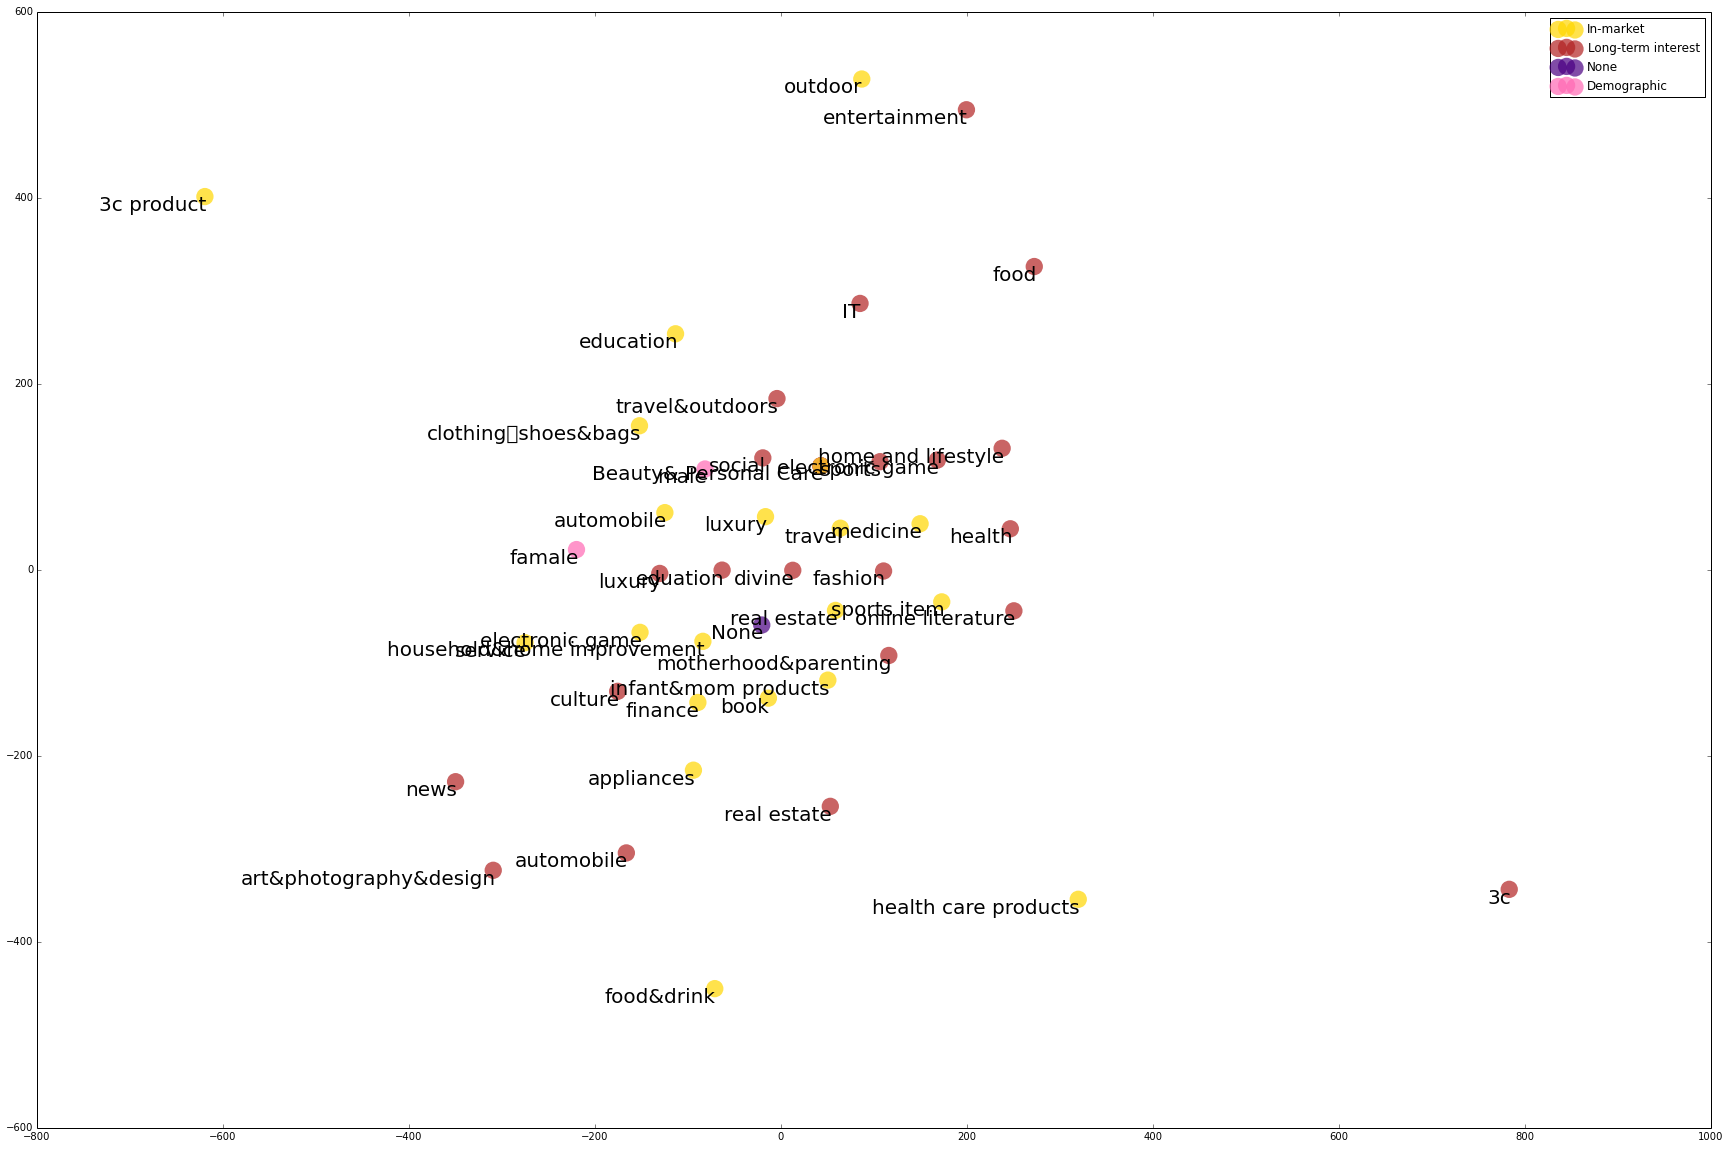

In [29]:
index = []

for key in dictionary.keys():
    if 'user_tags' in key:
        index.append(dictionary[key])
if len(index) > 500:
    index = index[0:500]
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=2000)
low_dim_embs = tsne.fit_transform(final_embeddings[index])
labels = [str(reverse_dictionary.get(i)).decode('utf-8').split('_')[-1] for i in index]
cates = [l.split('/')[0] for l in labels]
labels = [l.split('/')[-1] for l in labels]
plot_with_labels(low_dim_embs, labels, cates ,filename='tags_cboc_32_1272384.pdf')
# plot_with_labels(low_dim_embs, labels)

# Figure for domain

In [17]:
# # for domain, url, ip
# index = []
# for key in dictionary.keys():
#     if 'domain' in key:
#         index.append(dictionary[key])
# if len(index) > 500:
#     index = index[0:500]
# tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=500)
# low_dim_embs = tsne.fit_transform(final_embeddings[index])
# labels = [reverse_dictionary[i] for i in index]
# plot_with_labels(low_dim_embs, labels)

In [18]:
# index = []
# for key in dictionary.keys():
#     if 'adversiter_id' in key:
#         index.append(dictionary[key])
# if len(index) > 500:
#     index = index[0:500]
# tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=500)
# low_dim_embs = tsne.fit_transform(final_embeddings[index])
# labels = [reverse_dictionary[i] for i in index]
# plot_with_labels(low_dim_embs, labels)

# Figure for user agent

In [19]:
# index = []
# for key in dictionary.keys():
#     if 'user_agent' in key:
#         index.append(dictionary[key])
# if len(index) > 500:
#     index = index[0:500]
# tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=500)
# low_dim_embs = tsne.fit_transform(final_embeddings[index])
# labels = [reverse_dictionary[i] for i in index]
# plot_with_labels(low_dim_embs, labels)

# Figure for ip

In [20]:
# index = []
# for key in dictionary.keys():
#     if 'ip' in key:
#         index.append(dictionary[key])
# if len(index) > 500:
#     index = index[0:500]
# tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=500)
# low_dim_embs = tsne.fit_transform(final_embeddings[index])
# labels = [reverse_dictionary[i] for i in index]
# plot_with_labels(low_dim_embs, labels)

# Figure for url